# Obtaining Statistics of the RoomNav dataset

1. Average Geodesic Distances
2. Histogram of distances vs episodes
3. Average of top-down maps
4. Lenght of oracle

2019-07-29 21:55:40,529 initializing sim Sim-v0
I0729 21:55:40.536377 71698 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/2azQ1b91cZZ/2azQ1b91cZZ.navmesh
2019-07-29 21:55:50,289 initializing task Nav-v0


EPISODE COUNT: 800


I0729 21:56:13.520549 71698 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/X7HyMhZNoso/X7HyMhZNoso.navmesh
I0729 21:56:30.233211 71698 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/oLBMNvg9in8/oLBMNvg9in8.navmesh
I0729 21:56:45.734241 71698 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/zsNo4HB9uLZ/zsNo4HB9uLZ.navmesh


SPLIT:  val
Average Euclidean Distance:  7.727081631084327
Max Euclidean Distance:  28.2969745232525
Min Euclidean Distance:  1.7841792368277798
Average Geodesic Distance:  11.74952852845192
Max Geodesic Distance:  32.39596176147461
Min Geodesic Distance:  4.020570278167725


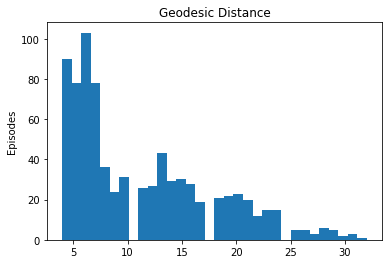

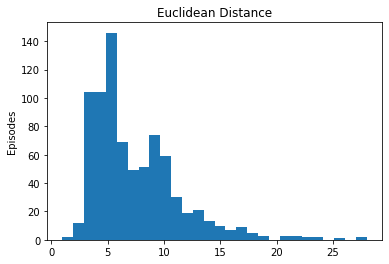

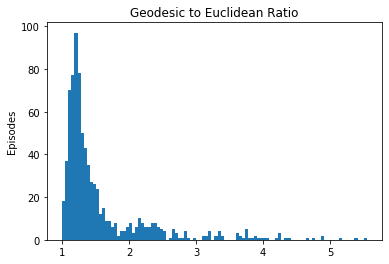

In [2]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

splits = ['val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}.json.gz'

for split in splits:
    
    avg_gd = 0
    avg_ed = 0
    min_gd = 10000000000
    max_gd = 0
    min_ed = 10000000000
    max_ed = 0
    
    gd_dists = []
    ed_dists = []
    gd2ed = []

    config = habitat.get_config(config_paths='../configs/tasks/pointnav_roomnav_mp3d.yaml')
    config.defrost()
    config.DATASET.DATA_PATH = data_path.format(split=split)
    config.DATASET.SCENES_DIR = '../data/scene_datasets/'
    config.freeze()
    
    env = habitat.Env(config=config)
    
    print('EPISODE COUNT:', len(env.episodes))

    for i in range(len(env.episodes)):
        observations = env.reset()
      
        sp = env.current_episode.start_position
        tp = env.current_episode.goals[0].position
        
        gd = env.sim.geodesic_distance(sp, tp)
        ed = np.power(np.power(np.array(sp) - np.array(tp), 2).sum(0), 0.5)
        
        gd2ed.append(gd/ed)
        gd_dists.append(gd)
        ed_dists.append(ed)

    env.close()
    
    ed_dists = np.asarray(ed_dists)
    gd_dists = np.asarray(gd_dists)
    gd2ed = np.asarray(gd2ed)
    
    print('SPLIT: ', split)
    print('Average Euclidean Distance: ', np.mean(ed_dists))
    print('Max Euclidean Distance: ', np.max(ed_dists))
    print('Min Euclidean Distance: ', np.min(ed_dists))
    
    print('Average Geodesic Distance: ', np.mean(gd_dists))
    print('Max Geodesic Distance: ', np.max(gd_dists))
    print('Min Geodesic Distance: ', np.min(gd_dists))
    
    plt.hist(gd_dists.astype(int), bins=int(np.max(gd_dists)))
    plt.title("Geodesic Distance")
    plt.ylabel('Episodes')
    plt.show()

    plt.hist(ed_dists.astype(int), bins=int(np.max(ed_dists)))
    plt.title("Euclidean Distance")
    plt.ylabel('Episodes')
    plt.show()
    
    plt.hist(np.around(gd2ed, decimals=4), bins=100)
    plt.title("Geodesic to Euclidean Ratio")
    plt.ylabel('Episodes')
    plt.show()
    

2019-07-29 23:03:10,365 initializing sim Sim-v0
I0729 23:03:10.372941 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/2azQ1b91cZZ/2azQ1b91cZZ.navmesh
2019-07-29 23:03:20,718 initializing task Nav-v0


800


I0729 23:03:37.438512 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/X7HyMhZNoso/X7HyMhZNoso.navmesh
I0729 23:03:50.071396 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/oLBMNvg9in8/oLBMNvg9in8.navmesh
I0729 23:04:03.823215 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/zsNo4HB9uLZ/zsNo4HB9uLZ.navmesh


SPLIT:  val
Average Euclidean Distance:  7.727081631084327
Max Euclidean Distance:  28.2969745232525
Min Euclidean Distance:  1.7841792368277798
Average Geodesic Distance:  11.74952852845192
Max Geodesic Distance:  32.39596176147461
Min Geodesic Distance:  4.020570278167725


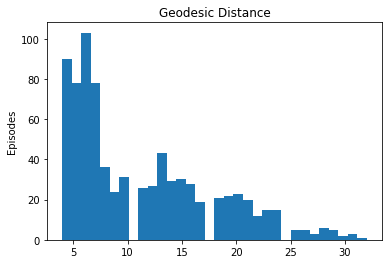

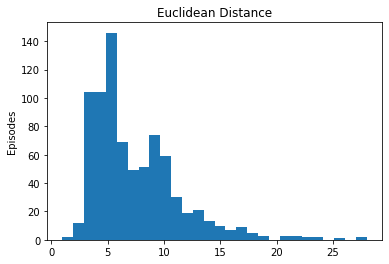

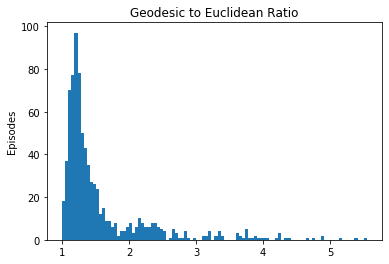

2019-07-29 23:04:12,128 initializing sim Sim-v0
I0729 23:04:12.135145 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/2t7WUuJeko7/2t7WUuJeko7.navmesh
2019-07-29 23:04:14,054 initializing task Nav-v0


500


I0729 23:04:15.254904 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/5ZKStnWn8Zo/5ZKStnWn8Zo.navmesh
I0729 23:04:26.154970 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/ARNzJeq3xxb/ARNzJeq3xxb.navmesh
I0729 23:04:31.914819 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/RPmz2sHmrrY/RPmz2sHmrrY.navmesh
I0729 23:04:35.180928 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/WYY7iVyf5p8/WYY7iVyf5p8.navmesh
I0729 23:04:40.115272 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-habitat/habitat-api/data/scene_datasets/mp3d/YFuZgdQ5vWj/YFuZgdQ5vWj.navmesh
I0729 23:04:46.302609 78010 simulator.py:78] Loaded navmesh /private/home/medhini/navigation-analysis-hab

SPLIT:  test
Average Euclidean Distance:  8.538436747777308
Max Euclidean Distance:  27.43771410550388
Min Euclidean Distance:  1.3008008842477259
Average Geodesic Distance:  11.119246767044068
Max Geodesic Distance:  33.66419219970703
Min Geodesic Distance:  4.000554084777832


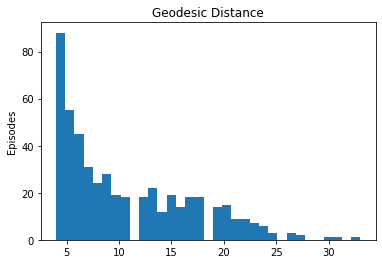

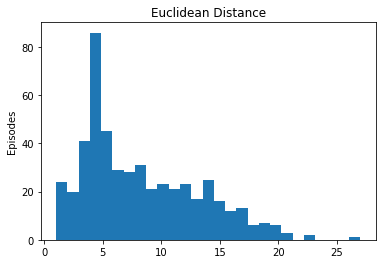

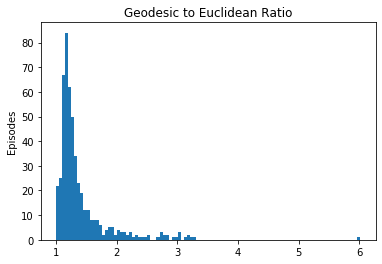

In [1]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

splits = ['val', 'test']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}.json.gz'

for split in splits:
    
    avg_gd = 0
    avg_ed = 0
    min_gd = 10000000000
    max_gd = 0
    min_ed = 10000000000
    max_ed = 0
    
    gd_dists = []
    ed_dists = []
    gd2ed = []

    config = habitat.get_config(config_paths='../configs/tasks/pointnav_roomnav_mp3d.yaml')
    config.defrost()
    config.DATASET.DATA_PATH = data_path.format(split=split)
    config.DATASET.SCENES_DIR = '../data/scene_datasets/'
    config.freeze()
    
    env = habitat.Env(config=config)
    
    print(len(env.episodes))

    for i in range(len(env.episodes)):
        observations = env.reset()
      
        sp = env.current_episode.start_position
        tp = env.current_episode.goals[0].position
        
        gd = env.sim.geodesic_distance(sp, tp)
        ed = np.power(np.power(np.array(sp) - np.array(tp), 2).sum(0), 0.5)
        
        gd2ed.append(gd/ed)
        gd_dists.append(gd)
        ed_dists.append(ed)

    env.close()
    
    ed_dists = np.asarray(ed_dists)
    gd_dists = np.asarray(gd_dists)
    gd2ed = np.asarray(gd2ed)
    
    print('SPLIT: ', split)
    print('Average Euclidean Distance: ', np.mean(ed_dists))
    print('Max Euclidean Distance: ', np.max(ed_dists))
    print('Min Euclidean Distance: ', np.min(ed_dists))
    
    print('Average Geodesic Distance: ', np.mean(gd_dists))
    print('Max Geodesic Distance: ', np.max(gd_dists))
    print('Min Geodesic Distance: ', np.min(gd_dists))
    
    plt.hist(gd_dists.astype(int), bins=int(np.max(gd_dists)))
    plt.title("Geodesic Distance")
    plt.ylabel('Episodes')
    plt.show()

    plt.hist(ed_dists.astype(int), bins=int(np.max(ed_dists)))
    plt.title("Euclidean Distance")
    plt.ylabel('Episodes')
    plt.show()
    
    plt.hist(np.around(gd2ed, decimals=4), bins=100)
    plt.title("Geodesic to Euclidean Ratio")
    plt.ylabel('Episodes')
    plt.show()
    

In [2]:
'''Oracle Path Lengths'''

import habitat_sim
import json
import gzip
from pydash import py_
import numpy as np
import tqdm
import glob

splits = ['train', 'test', 'val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}_all.json.gz'

for split in splits:
    with gzip.open(data_path.format(split=split), "rt") as f:
        episodes = json.load(f)["episodes"]

    act_path_lens = []
    for scene_id, eps in tqdm.tqdm(py_.group_by(episodes, "scene_id").items()):
        agent_cfg = habitat_sim.AgentConfiguration()
        sim_cfg = habitat_sim.SimulatorConfiguration()
        sim_cfg.scene.id = scene_id
        sim = habitat_sim.Simulator(
            habitat_sim.Configuration(sim_cfg, [agent_cfg])
        )

        for ep in tqdm.tqdm(eps, leave=False):
            state = sim.get_agent(0).state
            state.position = ep["start_position"]
            state.rotation = ep["start_rotation"]
            state.sensor_states = dict()

            sim.get_agent(0).state = state

            act_path_lens.append(
                len(
                    sim.make_greedy_follower().find_path(
                        ep["goals"][0]["position"]
                    )
                )
            )


    act_path_lens = np.array(act_path_lens)
    
    print('SPLIT: ', split)
    print("Min=", np.min(act_path_lens))
    print("Mean=", np.mean(act_path_lens))
    print("Median=", np.median(act_path_lens))
    print("Max=", np.max(act_path_lens))

  0%|          | 0/187500 [00:00<?, ?it/s]
                                          


AttributeError: 'Simulator' object has no attribute 'make_greedy_follower'

In [2]:
import os
import shutil

import cv2
import numpy as np

import habitat
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()

def get_original_map():
        top_down_map = maps.get_topdown_map(
            self._sim,
            self._map_resolution,
            self._num_samples,
            self._config.DRAW_BORDER,
        )

        range_x = np.where(np.any(top_down_map, axis=1))[0]
        range_y = np.where(np.any(top_down_map, axis=0))[0]

        self._ind_x_min = range_x[0]
        self._ind_x_max = range_x[-1]
        self._ind_y_min = range_y[0]
        self._ind_y_max = range_y[-1]
        return top_down_map

def draw_source_and_target(top_down_map, episode):
    # mark source point
    s_x, s_y = maps.to_grid(
        episode.start_position[0],
        episode.start_position[2],
        self._coordinate_min,
        self._coordinate_max,
        self._map_resolution,
    )
    point_padding = 2 * int(
        np.ceil(self._map_resolution[0] / MAP_THICKNESS_SCALAR)
    )
    top_down_map[
        s_x - point_padding : s_x + point_padding + 1,
        s_y - point_padding : s_y + point_padding + 1,
    ] = maps.MAP_SOURCE_POINT_INDICATOR

    # mark target point
    t_x, t_y = maps.to_grid(
        episode.goals[0].position[0],
        episode.goals[0].position[2],
        self._coordinate_min,
        self._coordinate_max,
        self._map_resolution,
    )
    top_down_map[
        t_x - point_padding : t_x + point_padding + 1,
        t_y - point_padding : t_y + point_padding + 1,
    ] = maps.MAP_TARGET_POINT_INDICATOR
    
    return top_down_map
    

def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(info["top_down_map"]["map"])
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

def shortest_path_example():
    
    splits = ['train', 'test', 'val']

    data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}.json.gz'

    for split in splits:
    
        config = habitat.get_config(config_paths="configs/tasks/roomnav_mp3d.yaml")
        config.defrost()
        config.DATASET.DATA_PATH = data_path.format(split=split)
        config.DATASET.SCENES_DIR = '../data/scene_datasets/'
        config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
        config.TASK.SENSORS.append("HEADING_SENSOR")
        config.freeze()
        
        outfile = 'AverageTopDown-{split}'.format(split=split)

        env = SimpleRLEnv(config=config)
        goal_radius = env.episodes[0].goals[0].radius
        if goal_radius is None:
            goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE
    #     follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)
    #     follower.mode = mode

        print("Environment creation successful")
        for episode in range(len(env.episodes)):
            observations = env.reset()
    #         dirname = os.path.join(
    #             IMAGE_DIR, "shortest_path_example", mode, "%02d" % episode
    #         )
    #         if os.path.exists(dirname):
    #             shutil.rmtree(dirname)
    #         os.makedirs(dirname)
            
            top_down_map =  env.get_info(observations)
            
            print(top_down_map)
#             top_down_map = draw_source_and_target(draw_source_and_target, env.episode)
            


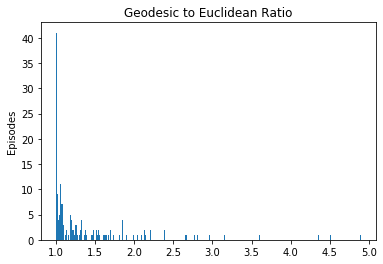

In [8]:
plt.hist(gd2ed, bins=600)
plt.title("Geodesic to Euclidean Ratio")
plt.ylabel('Episodes')
plt.show()